# 机器学习课程实践报告

### 概要
>
    股票市场由无数的投资者构成。每个投资者为个人经验、感情和不完全信息所左右，其决策立足于其他投资的决策以及汇总的信息中的随机事件，在经济学上研究这样的决策叫做博弈论。当然单个投资者的行为不可预测，但长期来看，股票价格作某种带漂移的无规则行走。
    
    底部放量是指某支股票股价处于低位时成交量放大。底部放量有三种走势：其一是放量上涨，一般是盘中主力所为；其二是放量下跌，一般为主力认赔出局；三是盘整放量，情况相对复杂，或是主力护盘，或是主力吸引市场买单，或是主力认赔出局。

    本实践主要目的是试图分析主力的行为，以此来预测股价未来一段时间的趋势（上涨、下跌以及扰动），可以为投资决策予以一定的参考。研究方法是基于股票价格变动以及成交量变动的数据，使用机器学习的方法进行预测，并对各机器学习的方法的预测效果予以对比和评价。


## 实验部分

## 一、使用机器学习算法进行股价趋势预测

### 1.1 导入相关的包

In [1]:
import os
import sys
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
from collections import defaultdict as ddict
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### 1.2 数据预处理

#### 定义tushare数据接口

In [2]:
pro = ts.pro_api('6ddbb5d15f9a2483d319b19fb0d973e677b25d1507b0b98539c272d8')

#### 定义一些时间

In [3]:
today = datetime.today().strftime('%Y%m%d')    # 获取今天的年月日
lastday = datetime.today() - timedelta(days=1)  # 获取前一天数据
lastday = lastday.strftime('%Y%m%d')
last_year = datetime.today() - relativedelta(months=12)   # 获取前一年的日期
last_year = last_year.strftime('%Y%m%d')   # 转换成str
Lastweek = datetime.today() - timedelta(days=7)   # 获取前一周的日期
Lastweek = Lastweek.strftime('%Y%m%d')

#### 获取所有正常上市交易的股票

In [4]:
stocks_b = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
all_stock = stocks_b['ts_code'] 
all_stock

0       000001.SZ
1       000002.SZ
2       000004.SZ
3       000005.SZ
4       000006.SZ
          ...    
4305    688777.SH
4306    688788.SH
4307    688819.SH
4308    688981.SH
4309    689009.SH
Name: ts_code, Length: 4310, dtype: object

#### 定义查找正例，负例及普通例样本的函数
>
    正例(放量上涨，positive)：短期内(25个交易日，为函数参数，可调)内几乎连续上涨的阶段，且上涨后的价格是上涨初期的价格的1.5倍以上(倍数为函数参数可调)。最后获取的数据是上涨初期前66（约莫三个自然月，为函数输入参数，可调整）个交易日的数据。  
    负例(放量下跌，negative)：短期内(25个交易日，为函数参数，可调)内几乎连续下降的阶段，且想下降初期的价格是下降后的价格的1.5倍以上(倍数为函数参数可调)。最后获取的数据是上涨初期前66（约莫三个自然月，为函数输入参数，可调整）个交易日的数据。   
    普通例(盘整放量，plain)：介于以上两者之间的66个交易日(约莫三个自然月，为函数输入参数，可调整)数据。要求：不包含连续上涨或下跌前66个交易日数据以及连续上涨或下跌初期往后25(函数参数，可调整)个交易日的数据。




In [5]:
def find_instances_and_labels(pro, stocks=None, specified_stocks=None, start_no=0, early_stop=100, time_span_years=2.5, duration=25,
                             times_for_up=1.5, times_for_down=1.5, continuous_slide_days=4, continuous_up_days=4,
                             three_trans_day_times=0.05, one_trans_day_times=0.00, days_back_required=66, plain_number=6):
    '''
    Arguments:
        pro: tushare获取数据的接口
        stocks: 含股票代码信息的可迭代容器, None or container
        specified_stocks: 指定的股票代码, None or an container (注意：stocks、specified_stocks不能同时为None)
        start_no: 初始股票大代码索引
        early_stop: 查询股票代码的个数上限
        time_span_years: 获取多少年前至今的日线行情数据
        duration: 股票(几乎在)连续上涨或下跌的最短时间
        times_for_up: 股票上涨后价格至少是上涨前价格的多少倍
        times_for_down: 股票下跌前至少是股票下跌后的多少倍
        continuous_slide_days: 在股票价格趋势为上涨阶段，不能被允许连续下跌的交易天数临界值
        continuous_up_days: 在股票价格趋势为下跌阶段，不能被允许连续下跌的交易天数临界值
        three_trans_day_times: 在股票价格连续上涨阶段，上涨初期后三个交易日的价格至少比初期价格上涨多少(比率)，用于修正上涨初期交易日
        one_trans_day_times: 在股票价格连续下降阶段，下降初期后一天的价格至少比下降初期的价格下降多少(比率)，用于修正下跌初期交易日
        days_back_required: 最后获取的数据是价格上涨初期或价格下跌初期或普通期前多少个交易日的数据
        plain_number: 单只股票最多获取普通例的个数。通常情况，普通例的个数比反常例(正例及负例)多。
    Returns:
        results: 含正例、负例即普通例数据的字典，数据包含股票代码，初期日的索引及交易日期
        outs: 含正例、负例即普通例数据的字典，数据包含股票代码及66(有些不足66)个交易日的trade_date, close, vol, vol_change, price_change
    '''
    start_date = datetime.today() - relativedelta(months=time_span_years*12)
    start_date = start_date.strftime('%Y%m%d')
    results = {'positive':{}, 'negative':{}, 'plain':{}}
    outs = {'positive':ddict(list), 'negative':ddict(list), 'plain':ddict(list)}
    try:
        queried_stock = stocks[start_no:] if specified_stocks is None else specified_stocks
    except:
        raise Exception('stocks and specified_stocks can not be None simultaneously!')
    for nnn, sk in enumerate(queried_stock):
        temp_res_pos = ddict(list)
        temp_res_neg = ddict(list)
        df = ts.pro_bar(api=pro, ts_code=sk, start_date=start_date, adj='qfq')
        if len(df) < 120:
            continue
        df = df[['ts_code', 'trade_date', 'close', 'vol']].sort_values(by='trade_date', ascending=True)
        df.reset_index(drop=True, inplace=True)
        # 标记涨跌情况
        df['up'] = (df['close']-df['close'].shift(1)) > 0
        df['down'] = (df['close']-df['close'].shift(1)) < 0
        # 计算成交量变化
        df['vol_change'] = (df['vol'] - df['vol'].shift(1))/df['vol'].shift(1)
        df['price_change'] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
        
        '''find negative instances'''
        found_neg = False # 初始化
        count_neg = 0 # 初始化
        temp_start_indices_neg = []
        for n, p in enumerate(df.close):
            if found_neg:
                if count_neg < duration:
                    count_neg += 1
                    continue
            count_neg = 0
            found_neg = False
            try:
                if df.loc[n, 'close']/df.loc[n+duration, 'close'] >= times_for_down and n >= 3:
                    invalid_neg = False
                    for k, up in enumerate(df.iloc[n:n+duration-continuous_up_days, 4]):
                        if sum(df.iloc[k+n:k+n+continuous_up_days, 4]) == continuous_up_days:
                            invalid_neg = True
                            break
                    if not invalid_neg:
                        found_neg = True
                        # 试图找到更加合适的大跌起始日
                        adding_days_neg = 0
                        for tt in range(duration):
                            if (df.loc[n+tt, 'close'] - df.loc[n+tt-1, 'close'])/df.loc[n+tt-1, 'close']  > -one_trans_day_times:
                                adding_days_neg += 1
                            else:
                                break
                        temp_res_neg[sk].append((n+adding_days_neg, df.loc[n+adding_days_neg, 'trade_date']))
            except: # 索引越界
                break
        if len(temp_res_neg):
            results['negative'].update(temp_res_neg)
            for val in temp_res_neg[sk]:
                temp_start_index_neg = val[0] - days_back_required if val[0] - days_back_required >= 0 else 0
                temp_start_indices_neg.append(temp_start_index_neg)
                if temp_start_index_neg >= val[0] - 1:
                    pass
                else:
                    outs['negative'][sk].append(df.values[temp_start_index_neg+3:val[0]+3, [1,2,3,6,7]]) # 保留的特征： trade_date, close, vol, vol_change, price_change
       
        '''find positive instances'''
        found_pos = False # 初始化
        count_pos = 0 # 初始化
        temp_start_indices_pos = []
        for n, p in enumerate(df.close):
            if found_pos:
                if count_pos < duration:
                    count_pos += 1
                    continue
            count_pos = 0
            found_pos = False
            try:
                if df.loc[n+duration, 'close']/df.loc[n, 'close'] >= times_for_up and n >= 3:
                    invalid_pos = False
                    for kk, fall in enumerate(df.iloc[n:n+duration-continuous_slide_days, 5]):
                        if sum(df.iloc[kk+n:kk+n+continuous_slide_days, 5]) == continuous_slide_days:
                            invalid_pos = True
                            break
                    if not invalid_pos:
                        found_pos = True
                        # 试图找到更加合适的大跌起始日
                        adding_days_pos = 0
                        for ttt in range(duration):
                            if df.loc[n+ttt, 'vol_change'] < 0.2:
                                adding_days_pos += 1
                            else:
                                break
                        temp_res_pos[sk].append((n+adding_days_pos, df.loc[n+adding_days_pos, 'trade_date']))
            except: # 索引越界
                break
        if len(temp_res_pos):
            results['positive'].update(temp_res_pos)
            for val in temp_res_pos[sk]:
                temp_start_index_pos = val[0] - days_back_required if val[0] - days_back_required >= 0 else 0
                temp_start_indices_pos.append(temp_start_index_pos)
                if temp_start_index_pos >= val[0] - 1:
                    pass
                else:
                    outs['positive'][sk].append(df.values[temp_start_index_pos+3:val[0]+3, [1,2,3,6,7]]) # 保留的特征： trade_date, close, vol, vol_change, price_change
        
        '''find plain instances'''
        # 寻找空当，既不是底部放量价格大幅上升阶段，也不是价格大幅下降阶段
        temp_available_date_interval = []
        # 价格大幅上升或价格大幅下降起始点的前days_back_required个交易日以及后duration个交易日已经被占用
        combined_start_indices = sorted([y for x in [temp_start_indices_neg, temp_start_indices_pos] for y in x])
        
        if len(combined_start_indices):
            last_index = 0 # 初始化
            for st in combined_start_indices:
                if (st-days_back_required) - (last_index+duration) >= days_back_required:
                    temp_available_date_interval.append((last_index+duration, st-days_back_required))
                    last_index = st
                else:
                    pass
            if len(df) - 1 - combined_start_indices[-1]+duration >= 2*days_back_required:
                temp_available_date_interval.extend([(i, i+days_back_required) for i in range(combined_start_indices[-1]+duration, len(df), days_back_required)])
        else:
            temp_available_date_interval = [(i, i+days_back_required) for i in range(0, len(df), days_back_required)]
            
        if temp_available_date_interval[-1][1] >= len(df):
            # 索引越界
            temp_available_date_interval.pop()
            
        if len(temp_available_date_interval):
            chose_plain_interval_indices = sorted(np.random.choice(range(len(temp_available_date_interval)), plain_number, replace=False)) \
                if len(temp_available_date_interval) > plain_number else list(range(len(temp_available_date_interval)))
#             for plain_interval_index in chose_plain_interval_indices:
            results['plain'].update({sk:[(temp_available_date_interval[index][1], df.loc[temp_available_date_interval[index][1], 'trade_date']) \
                                         for index in chose_plain_interval_indices]})
            outs['plain'][sk].extend([df.values[temp_available_date_interval[index][1]-days_back_required:temp_available_date_interval[index][1], [1,2,3,6,7]] \
                                         for index in chose_plain_interval_indices])
        else:
            pass
        
        if early_stop and specified_stocks is None:
            if nnn >= early_stop:
#                 print(results)
                return results, outs
            
#     print(results)
    return results, outs

#### 获取样例

In [6]:
res_all, out_all = find_instances_and_labels(pro, stocks=all_stock, early_stop=300, times_for_up=1.3, times_for_down=1.3)

#### 可视化

In [58]:
%matplotlib inline
plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'green', 'ytick.color':'green', 'figure.facecolor':'white'})
plt.rcParams['font.sans-serif']=['SimHei']

In [55]:
def plot_single(code, value, tendency):
    plt.figure(figsize=(8,6))
    plt.plot(range(value[0].shape[0]), value[0][:,-1], label='price change')
    plt.plot(range(value[0].shape[0]), value[0][:,-2], label='volume change')
    plt.xlabel('days')
    plt.ylabel('change rate')
    plt.title(f'{code} ({tendency})')
    plt.legend()
#     plt.savefig(f'/Users/ZZH/Desktop/420/{code} ({tendency}).png')
    

##### 盘整放量的样例

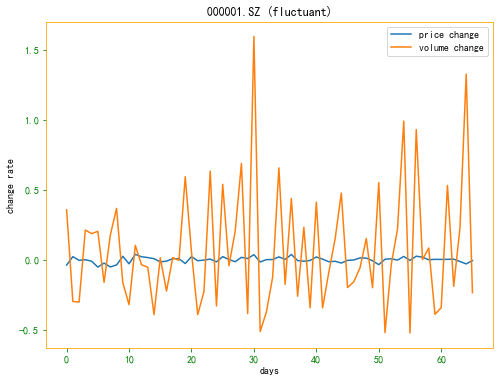

In [56]:
plot_single(*[(key, value, 'fluctuant') for key,value in list(out_all['plain'].items())[:1]][0])

##### 放量上涨的样例

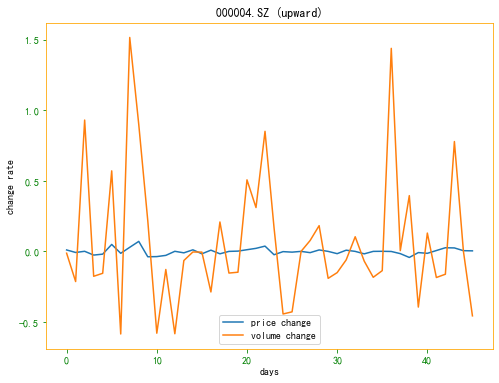

In [57]:
plot_single(*[(key, value, 'upward') for key,value in list(out_all['positive'].items())[:15]][1])

##### 放量下跌的样例

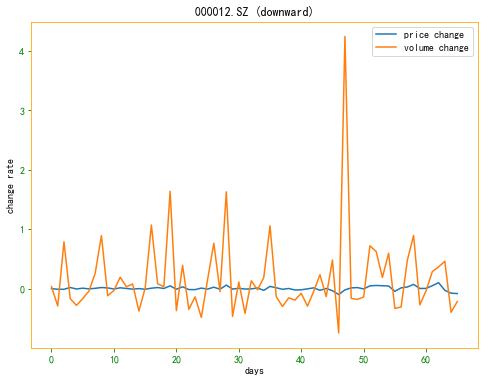

In [58]:
plot_single(*[(key, value, 'downward') for key,value in list(out_all['negative'].items())[:15]][7])

In [9]:
def plot(data):
    rows = len(data)
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20,16))
    for i,(key,value) in enumerate(data.items()):
        axes[i, 0].plot(range(value[0].shape[0]), value[0][:,-1])
        axes[i, 0].set_title(key+' price change ' + value[0][-1, 0])
        axes[i, 1].plot(range(value[0].shape[0]), value[0][:,-2], color='green')
        axes[i, 1].set_title(key+' volume change ' + value[0][-1, 0])
    plt.show()

##### 普通样例(盘整放量，plain)，只截取前15个用来作图

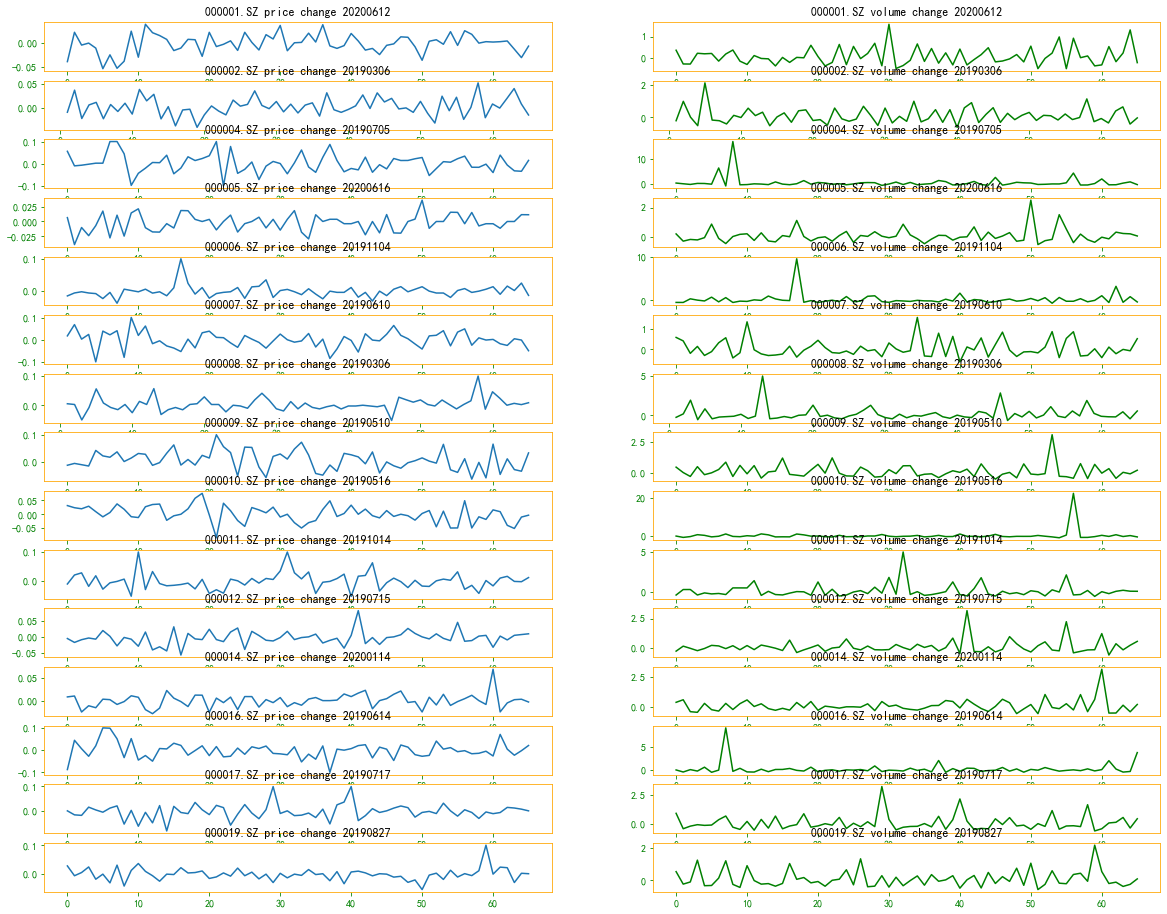

In [10]:
plot({key:value for key,value in list(out_all['plain'].items())[:15]}) 

##### 正例(放量上涨, positive)，只截取前15个用来作图

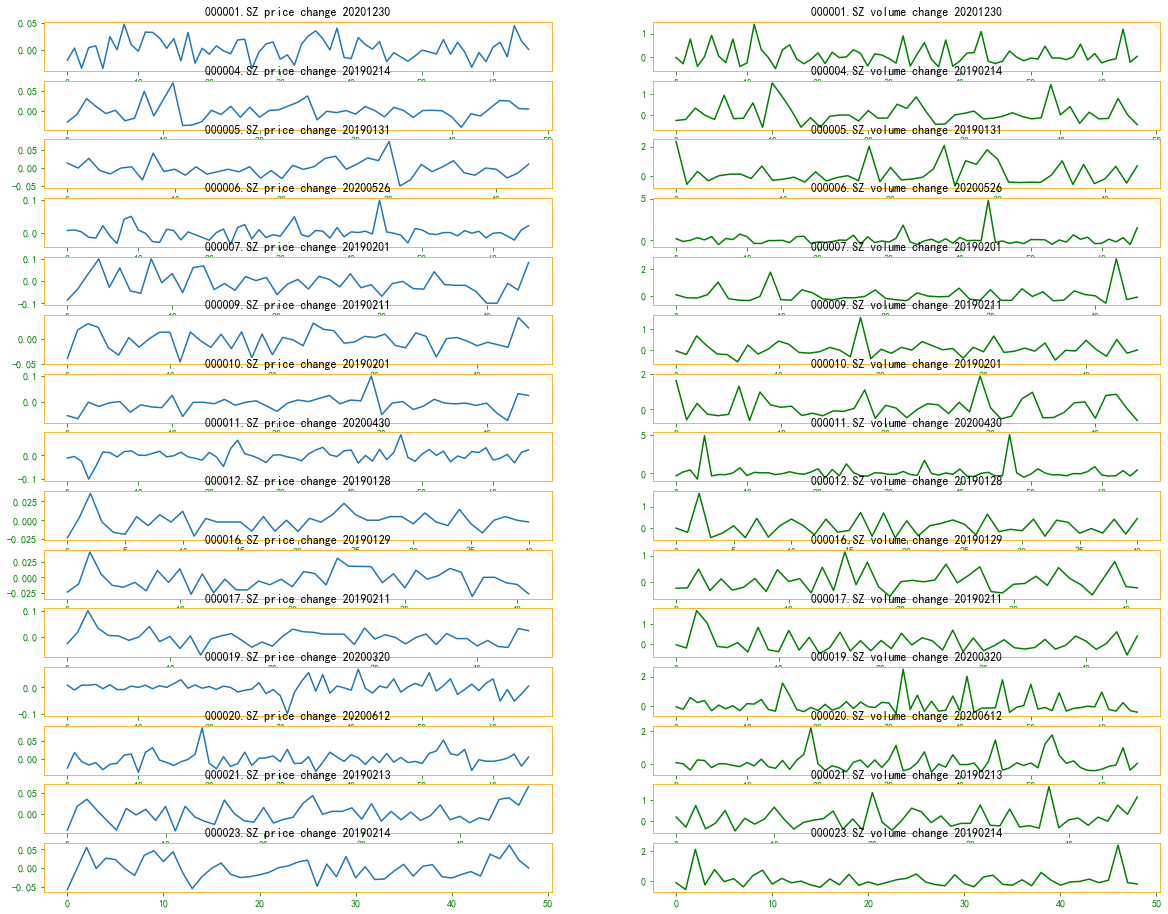

In [11]:
plot({key:value for key,value in list(out_all['positive'].items())[:15]}) # 只截取前15个用来作图

##### 负例(放量下跌，negative)，只截取前15个用来作图

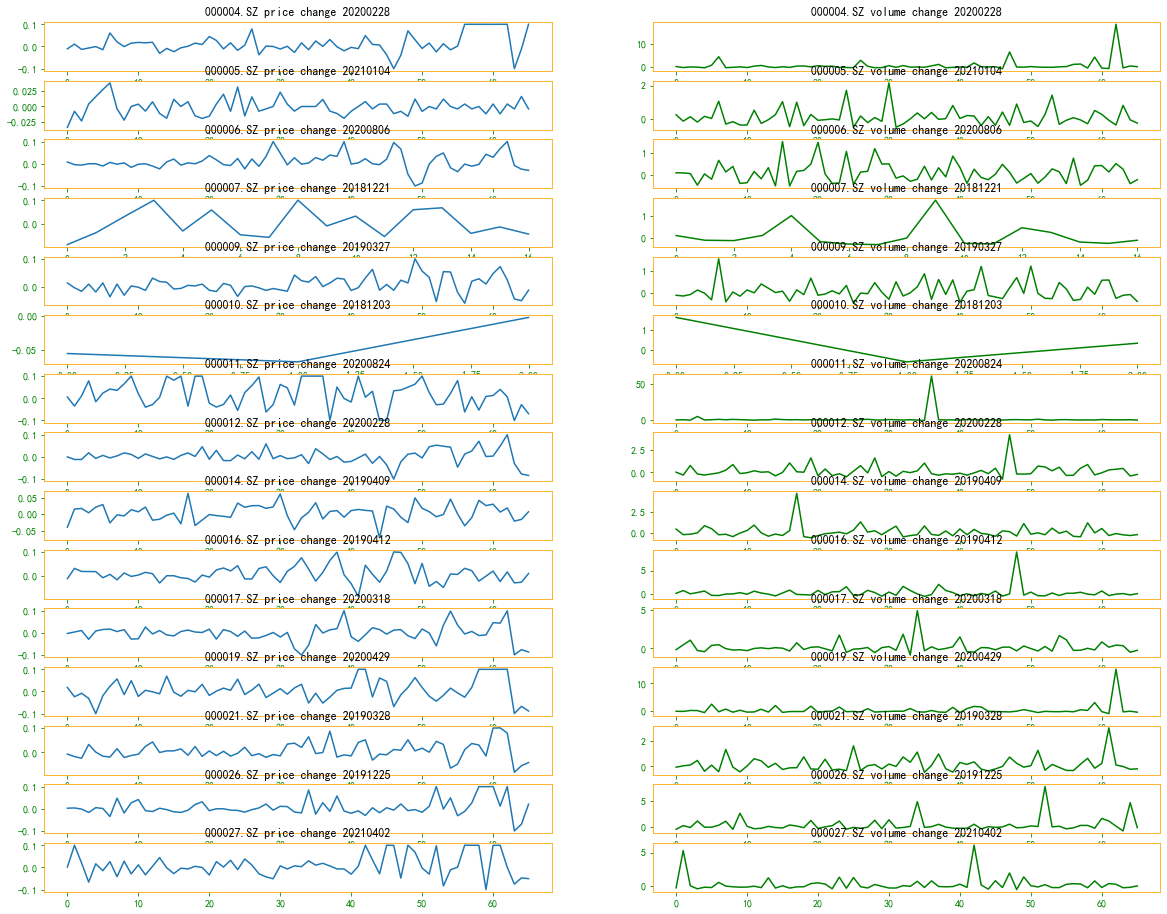

In [12]:
plot({key:value for key,value in list(out_all['negative'].items())[:15]}) # 只截取前15个用来作图

#### 样本总数

In [13]:
sum([sum([len(dd) for dd in d.values()]) for d in res_all.values()])

2293

#### 保存out_all为csv格式

In [14]:
data_out = []
dd = {'positive':1, 'negative':-1, 'plain':0}
for key, values in out_all.items():
    for code, vals in values.items():
        for val in vals:
            if len(val) == 66:
                data_out.append([y for x in [[code], list(val[:,-1]), list(val[:,-2]), [dd[key]]] for y in x])
                
df_out = pd.DataFrame(data_out, columns=[y for x in [['ts_code'],
                                             [f'pc_{i}' for i in range(66)],
                                             [f'vc_{i}' for i in range(66)],
                                             ['label']] for y in x])
df_out

,ts_code,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,...,vc_57,vc_58,vc_59,vc_60,vc_61,vc_62,vc_63,vc_64,vc_65,label
0,000001.SZ,-0.018283,0.003851,-0.032628,0.004626,0.007902,-0.033310,0.024999,0.000658,0.047432,...,0.543060,-0.143450,0.134372,-0.270871,-0.156160,-0.088274,1.201329,-0.241861,0.015996,1
1,000004.SZ,0.003193,0.000000,0.001061,-0.014308,-0.008602,0.011931,-0.019293,-0.039891,0.035287,...,0.387560,1.039036,-0.445200,-0.253752,-0.101936,-0.199772,1.683130,-0.010999,-0.066491,1
2,000004.SZ,0.070625,0.025599,0.004800,0.045541,0.022236,0.016091,-0.048680,-0.056412,-0.055211,...,-0.154147,-0.023043,-0.257359,0.150615,-0.147730,0.006341,0.423950,0.448555,-0.317227,1
3,000005.SZ,-0.003802,0.000000,0.022901,0.003731,-0.007435,0.000000,0.000000,0.000000,0.011236,...,1.350242,-0.630203,-0.287351,1.876095,-0.530361,-0.341100,0.422602,-0.352756,0.540416,1
4,000006.SZ,0.006234,0.008261,0.002048,-0.014309,-0.016612,0.021111,-0.010326,-0.033411,0.041043,...,0.136974,0.388786,-0.381457,-0.351514,0.156902,-0.174556,0.330381,-0.492307,1.517247,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,000788.SZ,-0.019900,-0.010152,0.071795,-0.043062,0.008333,-0.011570,0.003344,0.020000,-0.001634,...,-0.075920,0.775052,-0.314933,0.512278,-0.174348,0.146781,0.004344,-0.149813,11.287086,0
2099,000788.SZ,0.031117,-0.035665,-0.004267,-0.037143,0.014837,0.013158,-0.011544,0.010219,0.011561,...,0.166445,-0.506002,0.162619,-0.437079,0.055335,0.097771,-0.437030,0.135760,0.303844,0
2100,000788.SZ,0.023669,-0.013006,-0.004392,0.010294,0.042213,-0.012570,0.011315,-0.026573,-0.008621,...,0.217247,0.401473,-0.070002,-0.296238,0.269370,-0.153045,-0.265029,0.180919,0.482781,0
2101,000788.SZ,-0.009602,-0.026316,0.009957,-0.011268,-0.032764,0.013255,-0.002907,-0.004373,-0.005857,...,-0.226783,0.296141,-0.253225,-0.304535,-0.008082,0.206852,-0.024153,0.143688,-0.253887,0


#### 各类样本个数：（0表示盘整放量，1表示放量上涨，-1表示放量下跌）

In [15]:
Counter(df_out.label)

Counter({1: 465, -1: 422, 0: 1216})

#### 删除含nan的样例

In [16]:
print(len(df_out))
df_out.dropna(axis=0, inplace=True) # 删除含nan的行
print(len(df_out))

2103
2083


#### 按7:3划分训练集和测试(验证)集

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_out.values[:, 1:-1], np.array(df_out.label), test_size=.3)

##### 定义新的评价标准，给不同的类赋予不同的权重

In [17]:
def score(p_1, p_2, p_3):
    return p_1 * 0.4 + p_2 * 0.2 + p_3 * 0.4

#### 获取测试数据，不会参与模型的测试和验证过程的数据

In [19]:
res_spe, out_spe = find_instances_and_labels(pro, specified_stocks=['000788.SZ', '000800.SZ', '000812.SZ'], early_stop=300, times_for_up=1.3, times_for_down=1.3)

In [20]:
res_spe

{'positive': {'000788.SZ': [(46, '20190131')],
  '000800.SZ': [(58, '20190225'), (214, '20191030'), (376, '20200702')],
  '000812.SZ': [(37, '20190118'), (476, '20201112'), (516, '20210108')]},
 'negative': {'000788.SZ': [(78, '20190325')],
  '000800.SZ': [(85, '20190418')],
  '000812.SZ': [(89, '20190410'), (145, '20190703')]},
 'plain': {'000788.SZ': [(103, '20190430'),
   (169, '20190806'),
   (235, '20191114'),
   (301, '20200225'),
   (367, '20200602'),
   (499, '20201215')],
  '000800.SZ': [(244, '20191211'),
   (401, '20200806'),
   (467, '20201116'),
   (533, '20210224')],
  '000812.SZ': [(344, '20200427'), (541, '20210219')]}}

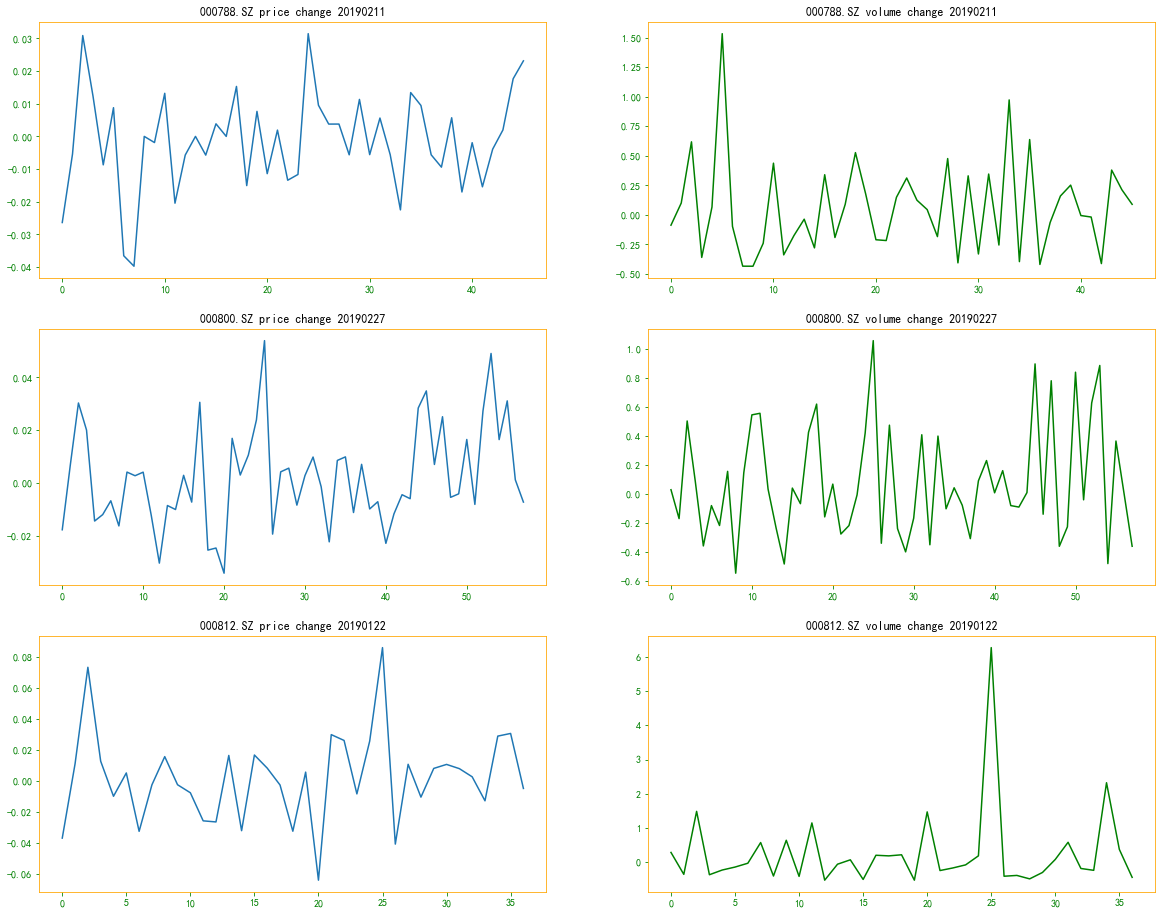

In [21]:
plot(out_spe['positive'])

#### 挑选某只(某些)股票最新的股票数据对其未来股票价格走势进行预测

In [7]:
def get_recent_stock_info(pro, stocks=None, end_date=datetime.today().strftime('%Y%m%d')):
    if stocks is None:
        return 
    results =  []
    sts = []
    for stock in stocks:
        df = ts.pro_bar(api=pro, ts_code=stock, start_date=last_year, end_date=end_date, adj='qfq')
        try:
            if len(df) < 67:
                continue
            sts.append(stock)
            df = df[['ts_code', 'trade_date', 'close', 'vol']].sort_values(by='trade_date', ascending=True)
            df.reset_index(drop=True, inplace=True)
            # 计算成交量变化
            df['vol_change'] = (df['vol'] - df['vol'].shift(1))/df['vol'].shift(1)
            # 计算价格变化
            df['price_change'] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
            results.append([y for x in [list(df['price_change'])[-66:], list(df['vol_change'])[-66:]] for y in x])
        except:
            pass
    return sts, results
        

### 1.3 使用随机森林来预测

#### 模型定义及训练(调参)过程

##### 初步调参

In [49]:
scores_alt = []
param_alt = []
count_alt = 0
'''
Parameters:
    n_estimators:10
    max_depth = None, usually between 10 and 100
    class_weight: None or balanced
    ...
'''
for n_estimators in range(10, 300, 20):
    for max_depth in range(50, 100):
        RFC = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced',
                                    random_state=1)
        RFC.fit(X_train, y_train)
        report = classification_report(y_test, RFC.predict(X_test), output_dict=True)
        scores_alt.append(score(report['-1']['f1-score'], report['0']['f1-score'], report['1']['f1-score']))
        param_alt.append((n_estimators, max_depth))
        if count_alt % 30 == 0:
            print(count_alt, scores_alt[-1], param_alt[-1])
        count_alt += 1

0 0.6226003993566473 (10, 50)
30 0.6226003993566473 (10, 80)
60 0.6137629669604845 (30, 60)
90 0.6137629669604845 (30, 90)
120 0.5924447504870197 (50, 70)
150 0.5827205596539311 (70, 50)
180 0.5827205596539311 (70, 80)
210 0.5504259579811968 (90, 60)
240 0.5504259579811968 (90, 90)
270 0.5825479764480512 (110, 70)
300 0.5751487077806646 (130, 50)
330 0.5751487077806646 (130, 80)
360 0.5988725464194332 (150, 60)
390 0.5988725464194332 (150, 90)
420 0.601554646903484 (170, 70)
450 0.5927830237311161 (190, 50)
480 0.5927830237311161 (190, 80)
510 0.5983735263139256 (210, 60)
540 0.5983735263139256 (210, 90)
570 0.5988207490871893 (230, 70)
600 0.602164159408815 (250, 50)
630 0.602164159408815 (250, 80)
660 0.5941440599749725 (270, 60)
690 0.5941440599749725 (270, 90)
720 0.6008293238489674 (290, 70)


In [50]:
best_index_RFC_alt = scores_alt.index(max(scores_alt))
print(best_index_RFC_alt, max(scores_alt), param_alt[best_index_RFC_alt])

0 0.6226003993566473 (10, 50)


##### 以上调参结果显示，基分类器个数应选择10，最大数深选择50
效果不佳，再进行调参

In [52]:
scores_alt_2 = []
param_alt_2 = []
count_alt_2 = 0
'''
Parameters:
    n_estimators:10
    max_depth = None, usually between 10 and 100
    class_weight: None or balanced
    ...
'''
for n_estimators in [y for x in [list(range(1,10)), list(range(10, 300, 20))] for y in x]:
    for max_depth in range(10, 100):
for n_estimators in range(1, 11):
    for max_depth in range(10, 51):
        RFC = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced',
                                    random_state=1)
        RFC.fit(X_train, y_train)
        report = classification_report(y_test, RFC.predict(X_test), output_dict=True)
        scores_alt_2.append(score(report['-1']['f1-score'], report['0']['f1-score'], report['1']['f1-score']))
        param_alt_2.append((n_estimators, max_depth))
        if count_alt_2 % 30 == 0:
            print(count_alt_2, scores_alt_2[-1], param_alt_2[-1])
        count_alt_2 += 1

0 0.4733307012719523 (1, 10)
30 0.44650507419020025 (1, 40)
60 0.45996506023204364 (2, 29)
90 0.5379230048748536 (3, 18)
120 0.5608793042640143 (3, 48)
150 0.5420534367166413 (4, 37)
180 0.5742569472377548 (5, 26)
210 0.5612216164969978 (6, 15)
240 0.5632113588339586 (6, 45)
270 0.5814738702550712 (7, 34)
300 0.5871084494257097 (8, 23)
330 0.6174921086719483 (9, 12)
360 0.5901162884097748 (9, 42)
390 0.6226003993566473 (10, 31)


In [53]:
best_index_RFC_alt_2 = scores_alt_2.index(max(scores_alt_2))
print(best_index_RFC_alt_2, max(scores_alt_2), param_alt_2[best_index_RFC_alt_2])

329 0.6891714950820511 (9, 11)


##### 以上调参结果显示，基分类器个数应选择9，最大数深选择11
效果仍不佳，再进行调参

In [65]:
scores_alt_3 = []
param_alt_3 = []
count_alt_3 = 0
'''
Parameters:
    n_estimators:10
    max_depth = None, usually between 10 and 100
    class_weight: None or balanced
    ...
'''
for n_estimators in [y for x in [list(range(1,10)), list(range(10, 300, 20))] for y in x]:
    for max_depth in range(10, 100):
        RFC = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced',
                                    random_state=1)
        RFC.fit(X_train, y_train)
        report = classification_report(y_test, RFC.predict(X_test), output_dict=True)
        scores_alt_3.append(score(report['-1']['f1-score'], report['0']['f1-score'], report['1']['f1-score']))
        param_alt_3.append((n_estimators, max_depth))
        if count_alt_3 % 30 == 0:
            print(count_alt_3, scores_alt_3[-1], param_alt_3[-1])
        count_alt_3 += 1
        
# best_index_RFC_alt_3 = scores_alt_3.index(max(scores_alt_3))
# print(best_index_RFC_alt_3, max(scores_alt_3), param_alt_3[best_index_RFC_alt_3])

0 0.4733307012719523 (1, 10)
30 0.44650507419020025 (1, 40)
60 0.44650507419020025 (1, 70)
90 0.4709270284384941 (2, 10)
120 0.45996506023204364 (2, 40)
150 0.45996506023204364 (2, 70)
180 0.5890508048622619 (3, 10)
210 0.5608793042640143 (3, 40)
240 0.5608793042640143 (3, 70)
270 0.6092463614793712 (4, 10)
300 0.5420534367166413 (4, 40)
330 0.5420534367166413 (4, 70)
360 0.6217398502319673 (5, 10)
390 0.5742569472377548 (5, 40)
420 0.5742569472377548 (5, 70)
450 0.6062480920303732 (6, 10)
480 0.5632113588339586 (6, 40)
510 0.5632113588339586 (6, 70)
540 0.6364913175125237 (7, 10)
570 0.5814738702550712 (7, 40)
600 0.5814738702550712 (7, 70)
630 0.6286581811003296 (8, 10)
660 0.5871084494257097 (8, 40)
690 0.5871084494257097 (8, 70)
720 0.6634699137493659 (9, 10)
750 0.5901162884097748 (9, 40)
780 0.5901162884097748 (9, 70)
810 0.6698291242251155 (10, 10)
840 0.6226003993566473 (10, 40)
870 0.6226003993566473 (10, 70)
900 0.7115101502526628 (30, 10)
930 0.6137629669604845 (30, 40)
960 

In [66]:
best_index_RFC_alt_3 = scores_alt_3.index(max(scores_alt_3))
print(best_index_RFC_alt_3, max(scores_alt_3), param_alt_3[best_index_RFC_alt_3])

2070 0.7144539894770017 (290, 10)


##### 以上调参结果显示，基分类器个数应选择290，最大数深选择10
效果有所提升，停止调参

#### 基于所选模型参数，查看模型对验证集的预测效果

In [67]:
RFC_classifier_best = RandomForestClassifier(n_estimators=290, max_depth=10, class_weight='balanced')
RFC_classifier_best.fit(X_train, y_train)
RFC_report_best = classification_report(y_test, RFC_classifier_best.predict(X_test), output_dict=True)
print(f"score: {score(RFC_report_best['-1']['f1-score'], RFC_report_best['0']['f1-score'], RFC_report_best['1']['f1-score'])}")
print('\n', classification_report(y_test, RFC_classifier_best.predict(X_test)))

score: 0.6940583759747294

               precision    recall  f1-score   support

          -1       0.83      0.64      0.72       135
           0       0.76      0.80      0.78       354
           1       0.60      0.65      0.62       136

    accuracy                           0.73       625
   macro avg       0.73      0.70      0.71       625
weighted avg       0.74      0.73      0.73       625



#### 查看模型对指定的股票的负样例进行预测

In [69]:
if len(out_spe['negative']['000788.SZ'][0]) == 66:
    temp_data = out_spe['negative']['000788.SZ'][0]
    print(RFC_classifier_best.predict([[y for x in [list(temp_data[:,-1]), list(temp_data[:,-2])] for y in x]]))

[-1]


#### 查看模型对指定的股票的普通样例进行预测

In [70]:
if len(out_spe['plain']['000812.SZ'][0]) == 66:
    temp_data = out_spe['plain']['000812.SZ'][0]
    print(RFC_classifier_best.predict([[y for x in [list(temp_data[:,-1]), list(temp_data[:,-2])] for y in x]]))

[0]


#### 获取测试数据，未参与模型的测试和验证过程的数据

In [36]:
new_res_all, new_out_all = find_instances_and_labels(pro, stocks=all_stock, start_no=300, early_stop=100, times_for_up=1.3, times_for_down=1.3)

In [37]:
data_to_test = []
dd = {'positive':1, 'negative':-1, 'plain':0}
for key, values in new_out_all.items():
    for code, vals in values.items():
        for val in vals:
            if np.isnan(val[0,-1]):
              print('omitted')
              continue
            if len(val) == 66:
                data_to_test.append([y for x in [[code], list(val[:,-1]), list(val[:,-2]), [dd[key]]] for y in x])

omitted
omitted
omitted
omitted


#### “最佳参数”的模型对测试样本的预测

In [71]:
RFC_classifier_best.predict([temp_data[1:-1] for temp_data in data_to_test])

array([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  0,
        0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  0,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1,  1,  0,
        1,  0,  1,  0,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,
        0,  0,  1,  1,  1,  0,  1,  0,  1,  0,  0,  1,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  1,  1,  1,
        1,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1,  0,  1,  0,  1,  1,  1,
        1,  0,  0,  0,  1,  1,  1,  1,  1,  0,  1,  0,  0,  0,  1,  1,  1,
        1,  1,  0,  1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
        1,  0,  1,  1,  0,  1,  1,  1,  1,  0, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1,  0,  0, -1, -1, -1, -1,  0, -1,  0,  0,  0,  0,  0,
        0, -1,  0, -1,  0,  0, -1, -1,  0,  0,  0, -1,  0,  0, -1,  0,  0,
        0,  0, -1, -1,  0

#### 查看模型对测试数据的预测效果

In [72]:
report = classification_report([temp_data[-1] for temp_data in data_to_test], 
                           RFC_classifier_best.predict([temp_data[1:-1] for temp_data in data_to_test]), output_dict=True)
print(classification_report([temp_data[-1] for temp_data in data_to_test], 
                           RFC_classifier_best.predict([temp_data[1:-1] for temp_data in data_to_test])))

              precision    recall  f1-score   support

          -1       0.91      0.57      0.70       160
           0       0.73      0.87      0.79       358
           1       0.75      0.72      0.73       180

    accuracy                           0.76       698
   macro avg       0.80      0.72      0.74       698
weighted avg       0.78      0.76      0.76       698



#### 自定义的评价标准(对不同类赋予不同的权重)下的模型对测试集的预测效果

In [73]:
score(report['-1']['f1-score'], report['0']['f1-score'], report['1']['f1-score'])

0.7323530856705247

### 1.4 增加样本数据进行训练，以期改善模型的预测效果

#### 加载数据

In [10]:
os.chdir('/Users/ZZH/Desktop/420') # 设置工作路径
ori_data = pd.read_csv('前300.csv') # 来自前300支股票的样本
ori_data_alt = pd.read_csv('400_700.csv') # 来自前第400到第700支股票的样本
ori_data_alt2 = pd.read_csv('700_1700.csv') # 来自前第700到第1700支股票的样本
df_out = pd.concat([ori_data, ori_data_alt, ori_data_alt2], axis=0)
# 查看前五个样本数据
df_out.head()

,ts_code,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,...,vc_57,vc_58,vc_59,vc_60,vc_61,vc_62,vc_63,vc_64,vc_65,label
0,000001.SZ,-0.018285,0.003854,-0.032630,0.004630,0.007900,-0.033312,0.025000,0.000659,0.047431,...,0.543060,-0.143450,0.134372,-0.270871,-0.156160,-0.088274,1.201329,-0.241861,0.015996,1
1,000004.SZ,0.003193,0.000000,0.001061,-0.014308,-0.008602,0.011931,-0.019293,-0.039891,0.035287,...,0.387560,1.039036,-0.445200,-0.253752,-0.101936,-0.199772,1.683130,-0.010999,-0.066491,1
2,000004.SZ,0.070625,0.025599,0.004800,0.045541,0.022236,0.016091,-0.048680,-0.056412,-0.055211,...,-0.154147,-0.023043,-0.257359,0.150615,-0.147730,0.006341,0.423950,0.448555,-0.317227,1
3,000005.SZ,-0.003802,0.000000,0.022901,0.003731,-0.007435,0.000000,0.000000,0.000000,0.011236,...,1.350242,-0.630203,-0.287351,1.876095,-0.530361,-0.341100,0.422602,-0.352756,0.540416,1
4,000006.SZ,0.006234,0.008261,0.002048,-0.014309,-0.016612,0.021111,-0.010326,-0.033411,0.041043,...,0.136974,0.388786,-0.381457,-0.351514,0.156902,-0.174556,0.330381,-0.492307,1.517247,1


##### 删除含空值的样本数据

In [11]:
print(len(df_out))
df_out.dropna(axis=0, inplace=True)
print(len(df_out))


11487
11472


##### 按相同比例划分训练集和验证集

In [12]:
sample, label = df_out.values[:,1:-1], df_out.values[:,-1]
label = label.astype('int')
label = label + 1  # 注意这里将训练样本的标签分别由-1,0,1转为0,1,2。为了和后面的深度学习的模型进行直观的对比
X_train, y_train = sample[0::2,], label[0::2]
X_test, y_test = sample[1::2,], label[1::2]

##### 各类样本个数：（0表示盘整放量，1表示放量上涨，-1表示放量下跌）

In [14]:
Counter(df_out['label'])

Counter({1: 2872, -1: 2570, 0: 6030})

#### 使用之前调参的结果定义“最佳”随机森林分类模型
290个基分类器，最大数深为10

In [15]:
RFC_classifier_best = RandomForestClassifier(n_estimators=290, max_depth=10, class_weight='balanced')
RFC_classifier_best.fit(X_train, y_train.astype('int'))
RFC_report_best = classification_report(y_test, RFC_classifier_best.predict(X_test), output_dict=True)


##### “最佳”随机森林分类模型对验证集的预测效果

In [19]:
print(f"score: {score(RFC_report_best['0']['f1-score'], RFC_report_best['1']['f1-score'], RFC_report_best['2']['f1-score'])}")
print('\n', classification_report(y_test.astype('int'), RFC_classifier_best.predict(X_test)))

score: 0.7819561607241029

               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1285
           1       0.87      0.71      0.78      3015
           2       0.66      0.93      0.77      1436

    accuracy                           0.78      5736
   macro avg       0.78      0.81      0.78      5736
weighted avg       0.80      0.78      0.78      5736



##### 显然，在增加训练样本的情况下，模型预测的效果有较大的改善

#### 获取测试样本
来自前第300到第400支股票的样本；start_no = 300, early_stop = 100

In [20]:
new_res_all, new_out_all = find_instances_and_labels(pro, stocks=all_stock, start_no=300, early_stop=100, times_for_up=1.3, times_for_down=1.3)

In [21]:
data_to_test = []
dd = {'positive':1, 'negative':-1, 'plain':0}
for key, values in new_out_all.items():
    for code, vals in values.items():
        for val in vals:
            if np.isnan(val[0,-1]):
              print('omitted')
              continue
            if len(val) == 66:
                data_to_test.append([y for x in [[code], list(val[:,-1]), list(val[:,-2]), [dd[key]]] for y in x])

omitted
omitted
omitted


##### “最佳”随机森林分类模型在测试集上的预测效果

In [22]:
report = classification_report([temp_data[-1]+1 for temp_data in data_to_test][:-3], 
                           RFC_classifier_best.predict([temp_data[1:-1] for temp_data in data_to_test][:-3]), output_dict=True)
print(classification_report([temp_data[-1]+1 for temp_data in data_to_test][:-3], 
                           RFC_classifier_best.predict([temp_data[1:-1] for temp_data in data_to_test][:-3])))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       161
           1       0.88      0.74      0.80       364
           2       0.69      0.96      0.80       181

    accuracy                           0.80       706
   macro avg       0.80      0.82      0.80       706
weighted avg       0.82      0.80      0.80       706



##### 预测效果分析
>
    模型对于负例(放量下跌)以及普通例(盘整放量的)的预测精度较高，分别为0.82和0.88，而对于正例(放量上涨)的预测精度一般(0.69)，
    模型对于负例(放量下跌)以及普通例(盘整放量的)的预测精度一般，分别为0.76和0.74，而对于正例(放量上涨)的预测精度较高(0.96),
    总体而言，模型倾向于预测股价的趋势为放量上涨；从f1分数来看，模型对各类样本的预测效果均尚可，数值都表现为在0.8附近。
    

##### 测试数据的各类样本个数：（1表示盘整放量，2表示放量上涨，0表示放量下跌）

In [23]:
Counter([temp_data[-1]+1 for temp_data in data_to_test][:-3])

Counter({2: 181, 0: 161, 1: 364})

#### 获取最新数据，但不知标签，对其未来股趋势进行预测
股票代码为'000001.SZ'、'600519.SH'以及 '000858.SZ'

In [24]:
sts, res = get_recent_stock_info(pro, stocks=['000001.SZ', '600519.SH', '000858.SZ'])

##### 预测'000001.SZ'、'600519.SH'以及 '000858.SZ'其未来一段时期的股价趋势

In [28]:
RFC_classifier_best.predict_proba(res)

array([[0.21513579, 0.69925292, 0.08561129],
       [0.23569998, 0.67625334, 0.08804668],
       [0.59412729, 0.37118012, 0.03469258]])

##### 趋势分析
从以上预测结果可知，'000001.SZ'、'600519.SH'在未来一段时间将会呈现上下波动的趋势(盘整放量)，概率分别为0.7和0.68  
而'000858.SZ'的股价在未来一段时间将会呈现下跌的趋势(放量下跌)，概率为0.59

### 1.5 对测试数据的预测结果进行分析
来自前第300到第400支股票的样本

In [29]:
index2trend =  {0:'downward', 1:'fluctuant', 2:'upward'}

In [65]:
def predict_trends(predictor, stks, data, i2t, real_trend=None):
    probs = predictor.predict_proba(data)
    prediction = pd.DataFrame(probs, columns=['dw_prob', 'f_prob', 'uw_prob'])
    prediction['stock'] = stks
    prediction['trend'] = [i2t[x] for x in np.argmax(probs, axis=1)]
    prediction['prob'] = np.max(probs, axis=1)
    prediction['prob'] = round(prediction['prob'], 2)
    prediction = prediction[['stock', 'dw_prob', 'f_prob', 'uw_prob', 'prob', 'trend']]
    prediction['real_trend'] = real_trend if real_trend is None else [i2t[y] for y in real_trend]
    prediction['accurate'] = None if real_trend is None else prediction['trend']==prediction['real_trend']
    return prediction
    

#### 将预测结果呈现为表格格式
各列含义：
>
    stock表示股票代码，dw_prob表示放量下跌的概率，f_prob表示盘整放量的概率，uw_prob表示放量上涨的概率  
    prob表示最大概率的未来股价趋势对应的概率，trend表示预测的未来股价趋势，real_trend表示真实的股价趋势，  
    accurate表示预测是否准确

In [67]:
pred2 = predict_trends(RFC_classifier_best, None, [temp_data[1:-1] for temp_data in data_to_test], index2trend,
                      real_trend=[temp_data[-1]+1 for temp_data in data_to_test])
pred2

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
0,None,0.049266,0.330625,0.620108,0.62,upward,upward,True
1,None,0.048098,0.284664,0.667238,0.67,upward,upward,True
2,None,0.053284,0.301390,0.645326,0.65,upward,upward,True
3,None,0.040008,0.319196,0.640796,0.64,upward,upward,True
4,None,0.124347,0.299236,0.576416,0.58,upward,upward,True
...,...,...,...,...,...,...,...,...
704,None,0.107032,0.526649,0.366319,0.53,fluctuant,fluctuant,True
705,None,0.047582,0.330916,0.621502,0.62,upward,fluctuant,False
706,None,0.077984,0.787980,0.134036,0.79,fluctuant,fluctuant,True
707,None,0.194035,0.693720,0.112245,0.69,fluctuant,fluctuant,True


##### 模型对测试数据的预测概率的平均值

In [68]:
pred2.prob.mean()

0.6131170662905501

##### 查看模型预测错误的样本

In [70]:
pred2.loc[pred2.accurate==False,]

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
49,None,0.550022,0.220562,0.229416,0.55,downward,upward,False
91,None,0.193079,0.418362,0.388559,0.42,fluctuant,upward,False
95,None,0.198896,0.429891,0.371213,0.43,fluctuant,upward,False
112,None,0.046137,0.562893,0.390971,0.56,fluctuant,upward,False
138,None,0.339997,0.369790,0.290213,0.37,fluctuant,upward,False
...,...,...,...,...,...,...,...,...
688,None,0.038230,0.341463,0.620307,0.62,upward,fluctuant,False
696,None,0.566187,0.379755,0.054058,0.57,downward,fluctuant,False
701,None,0.102739,0.357335,0.539926,0.54,upward,fluctuant,False
703,None,0.062409,0.297993,0.639598,0.64,upward,fluctuant,False


##### 模型预测错误的样板的预测概率的平均值

In [71]:
pred2.loc[pred2.accurate==False,].prob.mean()

0.5576595744680851

##### 模型预测正确的样板的预测概率的平均值

In [72]:
pred2.loc[pred2.accurate==True,].prob.mean()

0.6268838028169014

##### 按预测概率进行降序排列

In [73]:
pred2.sort_values(by='prob',ascending=False)

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
181,None,0.908060,0.071416,0.020524,0.91,downward,downward,True
195,None,0.865693,0.121906,0.012402,0.87,downward,downward,True
236,None,0.856551,0.121292,0.022157,0.86,downward,downward,True
258,None,0.860839,0.119651,0.019510,0.86,downward,downward,True
184,None,0.841923,0.146874,0.011203,0.84,downward,downward,True
...,...,...,...,...,...,...,...,...
428,None,0.316858,0.292634,0.390508,0.39,upward,fluctuant,False
644,None,0.282864,0.377886,0.339249,0.38,fluctuant,fluctuant,True
138,None,0.339997,0.369790,0.290213,0.37,fluctuant,upward,False
232,None,0.279645,0.352239,0.368116,0.37,upward,downward,False


##### 计算每个预测概率(保留两位小数)之上的预测准确率、预测准确样本数、累计预测样本数

In [85]:
prob_accuracy = {p:[round(sum(pred2.loc[pred2.prob>=p, 'accurate'])/len(pred2.loc[pred2.prob>=p, 'accurate']), 3),
                       sum(pred2.loc[pred2.prob>=p, 'accurate']),
                   len(pred2.loc[pred2.prob>=p, 'accurate'])] for p in sorted(pred2.prob.unique(), reverse=True)}
prob_accuracy

{0.91: [1.0, 1, 1],
 0.87: [1.0, 2, 2],
 0.86: [1.0, 4, 4],
 0.84: [1.0, 5, 5],
 0.83: [1.0, 11, 11],
 0.82: [1.0, 13, 13],
 0.81: [1.0, 16, 16],
 0.8: [1.0, 19, 19],
 0.79: [1.0, 23, 23],
 0.78: [1.0, 29, 29],
 0.77: [1.0, 35, 35],
 0.76: [0.978, 45, 46],
 0.75: [0.947, 54, 57],
 0.74: [0.954, 62, 65],
 0.73: [0.964, 80, 83],
 0.72: [0.97, 98, 101],
 0.71: [0.974, 111, 114],
 0.7: [0.962, 127, 132],
 0.69: [0.946, 140, 148],
 0.68: [0.939, 168, 179],
 0.67: [0.946, 192, 203],
 0.66: [0.939, 215, 229],
 0.65: [0.936, 249, 266],
 0.64: [0.914, 275, 301],
 0.63: [0.905, 297, 328],
 0.62: [0.9, 324, 360],
 0.61: [0.893, 342, 383],
 0.6: [0.887, 369, 416],
 0.59: [0.875, 384, 439],
 0.58: [0.872, 403, 462],
 0.57: [0.866, 421, 486],
 0.56: [0.854, 439, 514],
 0.55: [0.847, 453, 535],
 0.54: [0.841, 469, 558],
 0.53: [0.84, 488, 581],
 0.52: [0.838, 501, 598],
 0.51: [0.833, 513, 616],
 0.5: [0.826, 522, 632],
 0.49: [0.822, 531, 646],
 0.48: [0.819, 538, 657],
 0.47: [0.817, 549, 672],
 0.

#### 可视化

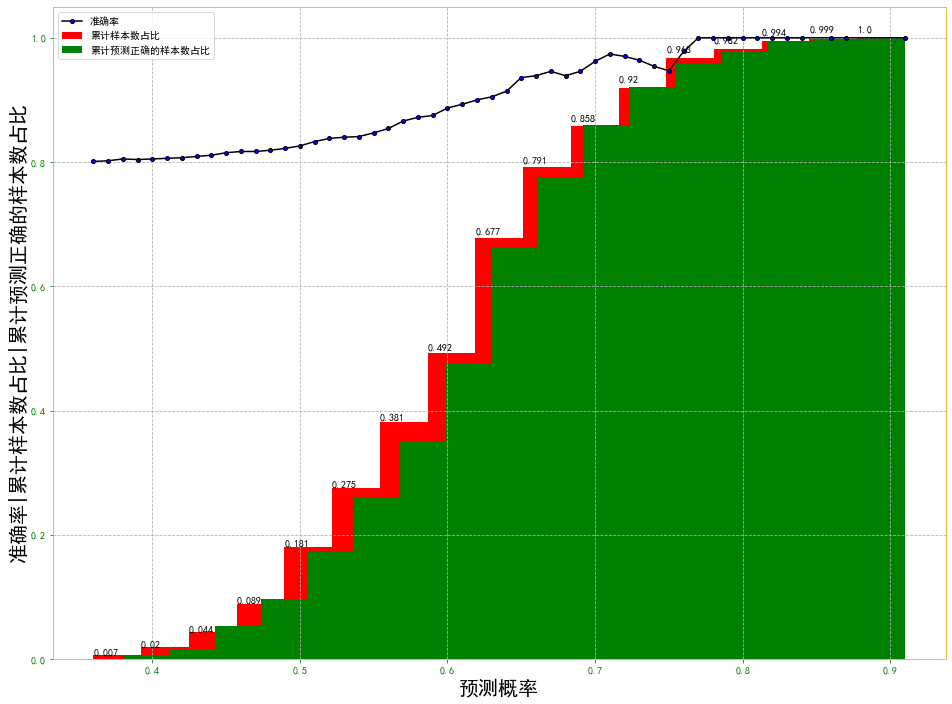

In [154]:
plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'green', 'ytick.color':'green', 'figure.facecolor':'white'})
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(16, 12))
n, bins, patches = plt.hist(pred2.prob,cumulative=True,density=True,bins=len(prob_accuracy)//3, histtype='bar', color='red',label='累计样本数占比')
# 打标签
for i in range(len(n)):
    plt.text(bins[i]*1.0, n[i]*1.01, round(n[i], 3)) # 打标签，在合适的位置标注每个直方图上面样本数
plt.hist(pred2.loc[pred2.accurate==True, 'prob'], cumulative=True, density=True,bins=len(prob_accuracy)//3, histtype='bar', color='green',label='累计预测正确的样本数占比')
plt.plot(list(prob_accuracy.keys()), [i[0] for i in prob_accuracy.values()], color='black', label='准确率',
        marker='o',markerfacecolor='blue', markersize=4) # markersize
plt.xlabel('预测概率', fontsize=20)
plt.ylabel('准确率|累计样本数占比|累计预测正确的样本数占比',fontsize=20)
plt.legend()
plt.grid(which='major',linestyle='--')
plt.savefig('/Users/ZZH/Desktop/420/figure.png')

#### 基于图形的预测结果解释 (数据来源于随机森林对测试集的预测结果) :
>
    预测的样本的概率主要集中在0.5-0.7左右；
    预测概率在0.75以上的样本极大可能是预测准确的；
    预测概率在0.75以上的样本数占比较小 (约5%)。


In [156]:
temp_ = pred2.sort_values(by='prob',ascending=False)
temp_.loc[temp_.accurate==False,]

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
361,None,0.755222,0.207901,0.036878,0.76,downward,fluctuant,False
408,None,0.753121,0.215226,0.031653,0.75,downward,fluctuant,False
631,None,0.746963,0.214834,0.038203,0.75,downward,fluctuant,False
525,None,0.030598,0.270597,0.698805,0.70,upward,fluctuant,False
433,None,0.033506,0.268204,0.698290,0.70,upward,fluctuant,False
...,...,...,...,...,...,...,...,...
584,None,0.273109,0.331340,0.395551,0.40,upward,fluctuant,False
428,None,0.316858,0.292634,0.390508,0.39,upward,fluctuant,False
138,None,0.339997,0.369790,0.290213,0.37,fluctuant,upward,False
232,None,0.279645,0.352239,0.368116,0.37,upward,downward,False


In [160]:
pred2.loc[pred2.prob>0.76,]

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
74,None,0.026003,0.143494,0.830503,0.83,upward,upward,True
181,None,0.908060,0.071416,0.020524,0.91,downward,downward,True
184,None,0.841923,0.146874,0.011203,0.84,downward,downward,True
188,None,0.771422,0.188590,0.039987,0.77,downward,downward,True
191,None,0.807925,0.165088,0.026987,0.81,downward,downward,True
195,None,0.865693,0.121906,0.012402,0.87,downward,downward,True
196,None,0.786450,0.180123,0.033426,0.79,downward,downward,True
230,None,0.807802,0.151977,0.040221,0.81,downward,downward,True
236,None,0.856551,0.121292,0.022157,0.86,downward,downward,True
242,None,0.825620,0.141910,0.032470,0.83,downward,downward,True


In [165]:
pred2.loc[pred2.accurate==False,].sort_values(by='prob',ascending=False).head(10)

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
361,None,0.755222,0.207901,0.036878,0.76,downward,fluctuant,False
408,None,0.753121,0.215226,0.031653,0.75,downward,fluctuant,False
631,None,0.746963,0.214834,0.038203,0.75,downward,fluctuant,False
433,None,0.033506,0.268204,0.698290,0.70,upward,fluctuant,False
525,None,0.030598,0.270597,0.698805,0.70,upward,fluctuant,False
577,None,0.024344,0.290089,0.685567,0.69,upward,fluctuant,False
499,None,0.043337,0.266819,0.689844,0.69,upward,fluctuant,False
628,None,0.692771,0.289399,0.017829,0.69,downward,fluctuant,False
377,None,0.058761,0.256835,0.684404,0.68,upward,fluctuant,False
611,None,0.029694,0.293532,0.676775,0.68,upward,fluctuant,False


### 1.6 基于最新的数据预测这些股票未来一段时间的股价趋势
股票范围：第300到第400支股票

In [171]:
sts_2, res_2 = get_recent_stock_info(pro, stocks=all_stock[300:400])

In [172]:
pred_new = predict_trends(RFC_classifier_best, sts_2, res_2, index2trend)
pred_new

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
0,000788.SZ,0.062445,0.346348,0.591207,0.59,upward,None,None
1,000789.SZ,0.323918,0.588078,0.088005,0.59,fluctuant,None,None
2,000790.SZ,0.492052,0.424291,0.083657,0.49,downward,None,None
3,000791.SZ,0.119881,0.666100,0.214019,0.67,fluctuant,None,None
4,000793.SZ,0.179273,0.539689,0.281038,0.54,fluctuant,None,None
...,...,...,...,...,...,...,...,...
95,000926.SZ,0.121990,0.782313,0.095697,0.78,fluctuant,None,None
96,000927.SZ,0.110402,0.734418,0.155180,0.73,fluctuant,None,None
97,000928.SZ,0.281236,0.555602,0.163162,0.56,fluctuant,None,None
98,000929.SZ,0.532239,0.396961,0.070799,0.53,downward,None,None


In [174]:
pred_new.sort_values(by='prob', ascending=False).head(30)

,stock,dw_prob,f_prob,uw_prob,prob,trend,real_trend,accurate
65,000888.SZ,0.154955,0.775255,0.069789,0.78,fluctuant,None,None
95,000926.SZ,0.121990,0.782313,0.095697,0.78,fluctuant,None,None
13,000803.SZ,0.107680,0.765929,0.126390,0.77,fluctuant,None,None
16,000809.SZ,0.113193,0.755365,0.131442,0.76,fluctuant,None,None
64,000887.SZ,0.107556,0.754933,0.137511,0.75,fluctuant,None,None
57,000878.SZ,0.142732,0.741893,0.115375,0.74,fluctuant,None,None
59,000881.SZ,0.104544,0.732910,0.162545,0.73,fluctuant,None,None
82,000910.SZ,0.107793,0.728961,0.163246,0.73,fluctuant,None,None
55,000876.SZ,0.116981,0.725730,0.157289,0.73,fluctuant,None,None
96,000927.SZ,0.110402,0.734418,0.155180,0.73,fluctuant,None,None


#### 分析
预测概率值较大的那些股票几乎都显示股价在未来一段时间内会是波动(盘整放量)的趋势，  
而少数股票显示其股价在未来一段时间内会是上升(放量上升)的(如000912.SZ，probability=0.69)